In [1]:
import pandas as pd
import numpy as np
import datetime
import dateutil.relativedelta

# load symbols

In [2]:
filepath = "/Users/Vincent/Desktop/nlp-stock-market-trend-prediction-with-reddit-posts/data/"

In [3]:
df_symbols = pd.read_pickle(filepath + "symbols.pd")

In [4]:
df_symbols["Symbol"] = df_symbols["Symbol"].astype(str).apply(lambda sym: sym.lower())

In [5]:
df_symbols.head()

,index,Symbol,Description,STOCK_EXCHANGE
0,0,aaa,First Priority Clo Bond ETF,AMEX
1,1,aaau,GS Physical Gold ETF,AMEX
2,2,aamc,Altisource Asset,AMEX
3,3,aau,Almaden Minerals,AMEX
4,4,abeq,Absolute Core Strategy ETF,AMEX


In [6]:
df_symbols.shape

(70064, 4)

# load reddit data

In [7]:
from common.tools import Reddit
import os

In [8]:
r = Reddit()

In [9]:
cols = ["id", "created_at", "title", "selftext", "score", "permalink", "num_comments", "ups", "upvote_ratio", "total_awards_received"]

subreddit = r.subreddits[-2]
subreddit

'wallstreetbets'

In [10]:
#df = pd.read_pickle(filepath + "wallstreetbets.pd")
df = r.load_raw_text(os.path.join(r.filepath, subreddit, "new"), cols)

In [11]:
df["has_selftext"] = list(map(int, df.selftext.str.len() != 0))
df["downs"] = df[["ups", "upvote_ratio"]].apply(lambda row: row[0]/row[1] - row[0], axis=1)

In [12]:
df.head()

,id,created_at,title,selftext,score,permalink,num_comments,ups,upvote_ratio,total_awards_received,has_selftext,downs
0,t3_pazmes,2021-08-25,$BB BlackBerry the sleeping giant (Potential $...,**My fellow APES** 🐵 **just remember that DIAM...,1082.0,/r/wallstreetbets/comments/pazmes/bb_blackberr...,188.0,1082.0,0.87,29.0,1,161.678161
1,t3_pb21jz,2021-08-25,FINRA VIOLATION - JP Morgan didn't enforce cov...,[FINRA violation pdf](https://www.finra.org/si...,102.0,/r/wallstreetbets/comments/pb21jz/finra_violat...,28.0,102.0,0.97,0.0,1,3.154639
2,t3_pb1v1v,2021-08-25,After being in hibernation since 2010 I think ...,,1.0,/r/wallstreetbets/comments/pb1v1v/after_being_...,31.0,1.0,0.51,0.0,0,0.960784
3,t3_pb1sa3,2021-08-25,Urban Outfitters $URBN Releases Quarterly Earn...,RECORD EARNINGS this quarter! Back when May 25...,4.0,/r/wallstreetbets/comments/pb1sa3/urban_outfit...,11.0,4.0,0.61,0.0,1,2.557377
4,t3_pb1iqr,2021-08-25,600k worth of CLNE YOLO,,84.0,/r/wallstreetbets/comments/pb1iqr/600k_worth_o...,37.0,84.0,0.81,2.0,0,19.703704


In [13]:
df.shape

(4220, 12)

# text pre-processing

## lower and remove punctuation etc.

In [14]:
import re
import string
import emoji

In [15]:
def get_emojis(text):
    return {c for c in text if c in emoji.UNICODE_EMOJI['en']}

In [16]:
def cleaning(text):
    text = text.lower()
    text = re.sub("\[.*\]", "", text)
    text = re.sub("\(.*\)", "", text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub("\w*\d\w*", "", text)
    text = re.sub("\s{2}", " ", text)
    text = text.encode("ascii", "ignore").decode("ascii") # removing emojis
    return text

In [17]:
df["title_clean"] = df.title.apply(cleaning)
df["text_clean"] = df.apply(lambda row: cleaning(row["title"] + " " + row["selftext"]), axis=1)
df["emojis"] = df.apply(lambda row: get_emojis(row["title"] + " " + row["selftext"]), axis=1)

## remove daily threads

In [18]:
df = df[~df.title_clean.str.contains("daily.*thread")]

In [19]:
df.shape

(4132, 15)

## remove stop words and tokenize

In [20]:
import nltk
nltk.download("stopwords")
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from nltk.corpus import words
nltk.download('words')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vincent\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vincent\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Vincent\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [21]:
stop_words = set(stopwords.words("english"))
stop_words.add("yolo")

In [22]:
len(stop_words & set(df_symbols["Symbol"].tolist()))

54

In [23]:
df["title_tokens"] = df.title_clean.apply(lambda t: [token for token in word_tokenize(t) if token not in stop_words])
df["text_tokens"] = df.text_clean.apply(lambda t: [token for token in word_tokenize(t) if token not in stop_words])

## filter stocks

In [24]:
from collections import Counter

In [25]:
symbols = set(df_symbols["Symbol"].tolist()) - set(words.words())
symbols.add("wish")
symbols.remove("yolo")
symbols.remove("app")
len(symbols)

65578

In [26]:
df["title_symbols"] = df.title_tokens.apply(lambda tokens: [token for token in tokens if token in symbols])
df["text_symbols"] = df.text_tokens.apply(lambda tokens: [token for token in tokens if token in symbols])

In [27]:
df["title_symbols"] = df.title_symbols.apply(Counter)
df["text_symbols"] = df.text_symbols.apply(Counter)

In [28]:
def remove_stocks(row, col):
    title, stocks = row[col], row["title_symbols"].keys()
    for stock in stocks:
        title = title.replace(stock, "")
    return title

In [29]:
df["title_clean_no_stocks"] = df.apply(lambda row: remove_stocks(row, "title_clean"), axis=1)

In [30]:
df["text_clean_no_stocks"] = df.apply(lambda row: remove_stocks(row, "text_clean"), axis=1)

In [31]:
df["title_tokens_clean"] = df.title_clean_no_stocks.apply(lambda t: [token for token in word_tokenize(t) if token not in stop_words])
df["text_tokens_clean"] = df.text_clean_no_stocks.apply(lambda t: [token for token in word_tokenize(t) if token not in stop_words])

In [32]:
df.shape

(4132, 23)

## stemming

In [33]:
sno = nltk.stem.SnowballStemmer("english")

In [34]:
df["title_tokens"] = df.title_tokens.apply(lambda tokens: [sno.stem(token) for token in tokens])
df["text_tokens"] = df.text_tokens.apply(lambda tokens: [sno.stem(token) for token in tokens])
df["title_tokens_clean"] = df.title_tokens_clean.apply(lambda tokens: [sno.stem(token) for token in tokens])
df["text_tokens_clean"] = df.text_tokens_clean.apply(lambda tokens: [sno.stem(token) for token in tokens])

## lemmatization

In [35]:
lem = nltk.stem.WordNetLemmatizer()

In [36]:
df["title_tokens"] = df.title_tokens.apply(lambda tokens: [lem.lemmatize(token, "v") for token in tokens])
df["text_tokens"] = df.text_tokens.apply(lambda tokens: [lem.lemmatize(token, "v") for token in tokens])
df["title_tokens_clean"] = df.title_tokens_clean.apply(lambda tokens: [lem.lemmatize(token, "v") for token in tokens])
df["text_tokens_clean"] = df.text_tokens_clean.apply(lambda tokens: [lem.lemmatize(token, "v") for token in tokens])

# Sentiment Analysis

In [37]:
df.shape

(4132, 23)

In [38]:
# take only entires where we have some symbols
df_sa = df[df.title_symbols.apply(len) > 0]

In [39]:
df_sa.shape

(2048, 23)

## lexicon-based
__Different lexicons__:
* AFINN
* Bing Liu's
* MPQA subjectivity
* SentiWordNet
* VADER
* TextBlob

### AFINN

In [40]:
from afinn import Afinn

In [41]:
af = Afinn()

In [42]:
df_sa["AFINN_polarity"] = df_sa.text_clean.apply(lambda text: af.score(text))

C:\Users\Vincent\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


### Bing Liu's

In [43]:
nltk.download("opinion_lexicon")
from nltk.corpus import opinion_lexicon

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\Vincent\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


In [44]:
pos = set(opinion_lexicon.positive())
neg = set(opinion_lexicon.negative())

In [45]:
df_sa["Bing_Liu_polarity"] = df_sa.text_tokens.apply(lambda tokens: sum(1 if token in pos else -1 if token in neg else 0 for token in tokens))

### Vader

In [46]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Vincent\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [47]:
sid = SentimentIntensityAnalyzer()

In [48]:
df_sa["VADER_polarity"] = df_sa.text_clean.apply(lambda text: sid.polarity_scores(text)["compound"])

### TextBlob

In [49]:
from textblob import TextBlob

In [50]:
df_sa["TextBlob_polarity"] = df_sa.text_clean.apply(lambda text: TextBlob(text).polarity)

### Word Embedding (CBOW)

In [51]:
from gensim.models import word2vec
from gensim.models.callbacks import CallbackAny2Vec
import matplotlib.pyplot as plt

C:\Users\Vincent\AppData\Roaming\Python\Python37\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [52]:
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0
        self.loss_history = list()

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            self.loss_history.append(loss)
            #print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            self.loss_history.append(loss- self.loss_previous_step)
            #print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

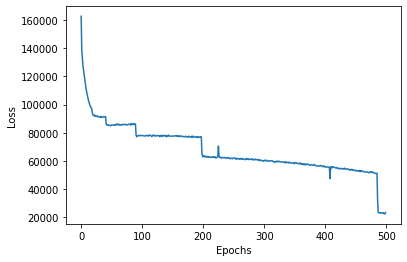

In [53]:
n_epochs = 500
c = callback()

cbow_model = word2vec.Word2Vec(
    df_sa.text_tokens,
    window=2,
    min_count=50,
    epochs=n_epochs,
    seed=99,
    compute_loss=True,
    callbacks=[c]
)

plt.plot(c.loss_history)
#plt.xticks(list(range(n_epochs)))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [54]:
cbow_model.wv.most_similar(positive="buy")

[('sell', 0.5744037628173828),
 ('hold', 0.40770286321640015),
 ('load', 0.37520596385002136),
 ('call', 0.355345755815506),
 ('ride', 0.3414630591869354),
 ('know', 0.332343190908432),
 ('get', 0.32751837372779846),
 ('put', 0.3207816183567047),
 ('retard', 0.30947229266166687),
 ('dip', 0.30738648772239685)]

In [55]:
cbow_model.wv.similarity(w1="buy", w2="sell")

0.5744037

In [56]:
def word_similarity(model, w1:str, w2:str):
    """similarity between two words"""
    try:
        return model.wv.similarity(w1=w1, w2=w2)
    except:
        return 0

In [57]:
df_sa["cbow_buy_polarity"] = df_sa.text_tokens_clean.apply(lambda tokens: max([word_similarity(cbow_model, "buy", token) for token in tokens] + [0]))
df_sa["cbow_sell_polarity"] = df_sa.text_tokens_clean.apply(lambda tokens: max([word_similarity(cbow_model, "sell", token) for token in tokens] + [0]))

C:\Users\Vincent\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


### Word Embedding (SKIP-GRAM)

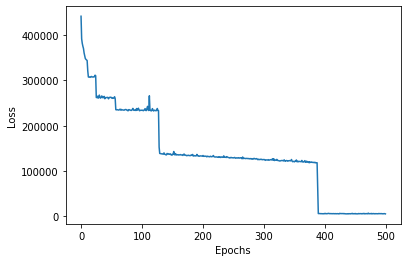

In [58]:
n_epochs = 500
c = callback()

sg_model = word2vec.Word2Vec(
    df_sa.text_tokens,
    window=2,
    min_count=50,
    epochs=n_epochs,
    sg=1,
    seed=99,
    compute_loss=True,
    callbacks=[c]
)

plt.plot(c.loss_history)
#plt.xticks(list(range(n_epochs)))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [59]:
sg_model.wv.most_similar(positive="buy")

[('sell', 0.658051609992981),
 ('hold', 0.4794946312904358),
 ('call', 0.4595557451248169),
 ('dip', 0.45901039242744446),
 ('share', 0.4541514217853546),
 ('know', 0.44832921028137207),
 ('put', 0.4394465684890747),
 ('get', 0.43467479944229126),
 ('posit', 0.4341924786567688),
 ('stock', 0.42742371559143066)]

In [60]:
df_sa["sg_buy_polarity"] = df_sa.text_tokens_clean.apply(lambda tokens: max([word_similarity(sg_model, "buy", token) for token in tokens] + [0]))
df_sa["sg_sell_polarity"] = df_sa.text_tokens_clean.apply(lambda tokens: max([word_similarity(sg_model, "sell", token) for token in tokens] + [0]))

### Emoji

In [61]:
#python -m pip install https://github.com/FintelLabs/emosent-py/archive/e5788e73e88f691b44fd5f6eda72187b559d99f2.tar.gz
from emosent import get_emoji_sentiment_rank

In [62]:
def get_emoji_score(emoji):
    try:
        return get_emoji_sentiment_rank(emoji)["sentiment_score"]
    except:
        return 0

In [63]:
df_sa["emoji_polarity"] = df_sa.emojis.apply(lambda emojis: max([get_emoji_score(emoji) for emoji in emojis] + [0]))

### Comparison

In [64]:
df_sa[["text_clean","AFINN_polarity", "Bing_Liu_polarity", "VADER_polarity", "TextBlob_polarity", "cbow_buy_polarity", "cbow_sell_polarity", "sg_buy_polarity", "sg_sell_polarity", "emoji_polarity"]].head(50)

,text_clean,AFINN_polarity,Bing_Liu_polarity,VADER_polarity,TextBlob_polarity,cbow_buy_polarity,cbow_sell_polarity,sg_buy_polarity,sg_sell_polarity,emoji_polarity
0,bb blackberry the sleeping giant my fellow ap...,30.0,14,0.9982,0.251447,0.574404,1.000000,0.658052,1.000000,0.621
1,finra violation jp morgan didnt enforce coveri...,-30.0,-12,-0.9835,-0.098769,1.000000,0.574404,1.000000,0.658052,0.000
3,urban outfitters urbn releases quarterly earni...,0.0,0,-0.2023,-0.033333,0.264867,0.294898,0.454151,0.441471,0.000
4,worth of clne yolo,2.0,1,0.4588,0.300000,0.054489,0.089496,0.157694,0.157396,0.000
6,gme gang to the moon,0.0,0,0.0000,0.000000,0.073863,0.000000,0.143605,0.128730,0.000
8,gme baby,0.0,0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
9,to the moon lfg hodl,0.0,0,0.0000,0.000000,0.073863,0.000000,0.143605,0.128730,0.000
17,light work on panw overnight,0.0,1,0.0000,0.400000,0.000000,0.129314,0.084861,0.215364,0.000
19,bb has the potential to make some serious move...,-5.0,2,-0.1851,0.016095,0.574404,1.000000,0.658052,1.000000,0.000
21,im up get the bottles out bb,0.0,0,0.0000,0.000000,0.327518,0.253828,0.434675,0.498942,0.000


# Latent Dirichlet Allocation (LDA)

In [65]:
import gensim
from gensim import corpora
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models

In [66]:
df_sa["title_bigrams"] = df_sa.title_tokens_clean.apply(lambda t: ["_".join(bigram) for bigram in nltk.bigrams(t)])

C:\Users\Vincent\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [67]:
id2word = corpora.Dictionary(df_sa.title_tokens_clean)
#id2word = corpora.Dictionary(df_sa.title_bigrams)

8716 | INFO | adding document #0 to Dictionary(0 unique tokens: [])
8716 | INFO | built Dictionary(2620 unique tokens: ['blackberri', 'giant', 'sleep', 'bag', 'compet']...) from 2048 documents (total 9649 corpus positions)
8716 | INFO | Dictionary lifecycle event {'msg': "built Dictionary(2620 unique tokens: ['blackberri', 'giant', 'sleep', 'bag', 'compet']...) from 2048 documents (total 9649 corpus positions)", 'datetime': '2021-08-28T14:06:13.266235', 'gensim': '4.0.1', 'python': '3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}


In [68]:
corpus = [id2word.doc2bow(tokens) for tokens in df_sa.title_tokens_clean]
#corpus = [id2word.doc2bow(tokens) for tokens in df_sa.title_bigrams]

## hyperparameter tuning

In [69]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [70]:
df_sa.shape

(2048, 33)

In [71]:
def tuning_lda_model(n_topics, alpha="symmetric", eta=None):
    lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=n_topics,
        random_state=100,
        update_every=1,
        chunksize=1500,
        passes=10,
        alpha=alpha,
        eta=eta,
        per_word_topics=True,
    )
    return lda_model

In [72]:
# Topic parameter
topics = range(2,80)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.05))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
eta = list(np.arange(0.1, 1, 0.05))
eta.append('symmetric')

In [73]:
%matplotlib qt

In [74]:
# topics tuning

if False:
    previous_score = 0
    topic_scores = list()
    for n_topics in topics:
        lda_model = tuning_lda_model(n_topics)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=df_sa.title_tokens_clean, dictionary=id2word, coherence="c_v")
        score = coherence_model_lda.get_coherence()
        if score > previous_score:
            previous_score = score
            best_n_topics = n_topics
        topic_scores.append(score)
        print(n_topics, score)

    plt.plot(topic_scores)
    plt.xticks(range(len(topics)), topics, rotation=-45)
    plt.xlabel("Topics")
    plt.ylabel("Coherence_score")
    plt.show()
    
    print(best_n_topics)

In [75]:
# alpha tuning

if False:
    previous_score = 0
    alpha_scores = list()
    for a in alpha:
        lda_model = tuning_lda_model(33, a)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=df_sa.title_tokens_clean, dictionary=id2word, coherence="c_v")
        score = coherence_model_lda.get_coherence()
        if score > previous_score:
            previous_score = score
            best_alpha = a
        alpha_scores.append(score)
        print(a, score)

    plt.plot(alpha_scores)
    plt.xticks(range(len(alpha)), [round(a, 2) if type(a) == np.float64 else a for a in alpha], rotation=-45)
    plt.xlabel("Alpha")
    plt.ylabel("Coherence_score")
    plt.show()
    
    print(best_alpha)

In [76]:
# eta tuning

if False:
    previous_score = 0
    eta_scores = list()
    for e in eta:
        lda_model = tuning_lda_model(33, 0.96, e)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=df_sa.title_tokens_clean, dictionary=id2word, coherence="c_v")
        score = coherence_model_lda.get_coherence()
        if score > previous_score:
            previous_score = score
            best_eta = e
        eta_scores.append(score)
        print(e, score)
    
    plt.plot(eta_scores)
    plt.xticks(range(len(eta)), [round(e, 2) if type(e) == np.float64 else e for e in eta], rotation=-45)
    plt.xlabel("Eta")
    plt.ylabel("Coherence_score")
    plt.show()
    
    print(best_eta)

In [77]:
%matplotlib inline

# model

In [78]:
# create final model

if False:
    lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=33,
        random_state=100,
        update_every=1,
        chunksize=1500,
        passes=10,
        alpha=0.96,
        eta="symmetric",
        per_word_topics=True)

    coherence_model_lda = CoherenceModel(model=lda_model, texts=df_sa.title_tokens_clean, dictionary=id2word, coherence="c_v")
    print(coherence_model_lda.get_coherence())

In [79]:
# safe model

if False:
    filepath = "/Users/Vincent/Desktop/nlp-stock-market-trend-prediction-with-reddit-posts/models/lda_model.model"
    lda_model.save(filepath)

In [80]:
# load model
if True:
    filepath = "/Users/Vincent/Desktop/nlp-stock-market-trend-prediction-with-reddit-posts/models/lda_model.model"
    lda_model = gensim.models.ldamodel.LdaModel.load(filepath)
        
    id2word = lda_model.id2word
    corpus = [id2word.doc2bow(tokens) for tokens in df_sa.title_tokens_clean]
    #lda_model[corpus]
    
    lda_model.update(corpus)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=df_sa.title_tokens_clean, dictionary=id2word, coherence="c_v")
    print(coherence_model_lda.get_coherence())

0.6332071075851413


## evaluation

__interesting topics:__
* 3 - buy
* 8 - earn
* 12 - save
* 13 - bought
* 15 - sell
* 16 - rise
* 17 - moon
* 28 - drop

In [81]:
topics_definition = {
    "positiv": [3,5,10,11,12,14,23],
    "negativ": [6,22],
}

In [82]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

C:\Users\Vincent\AppData\Roaming\Python\Python37\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
17     0.012276 -0.056881       1        1  3.325105
14    -0.008956 -0.051590       2        1  3.176632
27     0.124522 -0.155108       3        1  3.158229
21    -0.226339  0.100308       4        1  3.144017
13    -0.027728  0.025617       5        1  3.143882
4     -0.119016 -0.038180       6        1  3.109089
24    -0.080052 -0.034199       7        1  3.097655
23     0.004257  0.025205       8        1  3.070831
28    -0.061042 -0.055625       9        1  3.069548
5      0.014291 -0.037832      10        1  3.061978
15     0.014727 -0.028466      11        1  3.059559
6      0.006803 -0.027355      12        1  3.058951
32     0.011557 -0.040991      13        1  3.045664
18     0.111170  0.215606      14        1  3.040559
20     0.100357  0.158391      15        1  3.039974
30    -0.146955 -0.013393      16        1  3.034006
10     0.011332 -0.030185      17        1  3.031809
25     0.046106  0.037923      18        1  3.025661
19    -0.009272 -0.013329      19        1  3.008434
11    -0.090442 -0.004476      20        1  3.007513
7      0.004630 -0.029619      21        1  3.004969
29     0.047209  0.049173      22        1  3.004656
8      0.122660 -0.169605      23        1  3.002206
9      0.011543 -0.031618      24        1  2.998747
0     -0.021218 -0.032920      25        1  2.996783
26    -0.121116  0.033258      26        1  2.995612
16     0.016230 -0.027488      27        1  2.953189
22     0.108270  0.132185      28        1  2.945610
3      0.104965  0.079398      29        1  2.919776
1      0.054690  0.164483      30        1  2.890280
31     0.041608 -0.068986      31        1  2.889489
12     0.088248 -0.114267      32        1  2.877383
2     -0.145318  0.040565      33        1  2.812204, topic_info=       Term        Freq       Total Category  logprob  loglift
47      buy  125.000000  125.000000  Default  30.0000  30.0000
59       go  110.000000  110.000000  Default  29.0000  29.0000
16     earn   90.000000   90.000000  Default  28.0000  28.0000
60   option   88.000000   88.000000  Default  27.0000  27.0000
97     week   95.000000   95.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
50     gain    0.027095   73.236610  Topic33  -9.2118  -4.3309
306   still    0.027079   53.554439  Topic33  -9.2124  -4.0185
359     new    0.027074   28.260087  Topic33  -9.2126  -3.3794
96     play    0.027049  110.431782  Topic33  -9.2135  -4.7433
143    next    0.027048   70.377180  Topic33  -9.2136  -4.2928

[1416 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
692       9  0.883951    absolut
295       9  0.970332    account
193      22  0.844898   acquisit
289      29  0.985038     action
714       4  0.982825     actual
...     ...       ...        ...
74       11  0.988491       year
830      18  0.939489  yesterday
537      13  0.979331        yet
434       5  0.958396       yolo
1073     13  0.960227      yolod

[627 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 15, 28, 22, 14, 5, 25, 24, 29, 6, 16, 7, 33, 19, 21, 31, 11, 26, 20, 12, 8, 30, 9, 10, 1, 27, 17, 23, 4, 2, 32, 13, 3])

## Apply LDA model on DataFrame

In [83]:
def lda_score_threshold(tokens, threshold=0.05):
    bow = id2word.doc2bow(tokens)
    return [topic for topic, score in lda_model[bow][0] if score > threshold]

In [84]:
df_sa["topics"] = df_sa.title_tokens_clean.apply(lda_score_threshold)

C:\Users\Vincent\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [85]:
no_topic = sum(df_sa.topics.str.len() == 0)
has_topic = sum(df_sa.topics.str.len() >= 1)
print("df_size:", df_sa.shape[0], "\ndf_no_topic_found:", no_topic / df_sa.shape[0] * 100, "\ndf_topics_found:", has_topic / df_sa.shape[0] * 100)

df_size: 2048 
df_no_topic_found: 12.3046875 
df_topics_found: 87.6953125


## Results

### (NO LONGER USED) Top 3 stock symbols per day

In [86]:
polarity_cols = df_sa.columns[df_sa.columns.str.contains(r"polarity$")].tolist()
polarity_cols

['AFINN_polarity',
 'Bing_Liu_polarity',
 'VADER_polarity',
 'TextBlob_polarity',
 'cbow_buy_polarity',
 'cbow_sell_polarity',
 'sg_buy_polarity',
 'sg_sell_polarity',
 'emoji_polarity']

In [87]:
stock_polarity_cols = [polarity + "_stock_score" for polarity in polarity_cols]
# score is based on all symbols per day, not a subset (e.g. "SPCE" got 50 threads for one day, but only 20 are in the relevant ones -> but the calculation is done on the 50)
series = df_sa[["title_symbols"] + polarity_cols].apply(lambda row: [Counter({symbol: polarity for symbol in row["title_symbols"]}) for polarity in row[polarity_cols]], axis=1)
df_sa[stock_polarity_cols] = pd.DataFrame(series.tolist(), index=series.index)

In [88]:
df_sa["thread_score_per_stock"] = df_sa[["title_symbols", "score"]].apply(lambda row: Counter({symbol: row["score"] for symbol in row["title_symbols"].keys()}), axis=1)

In [89]:
def update_counters(series):
    total = Counter()
    for counter in series.tolist():
        if not type(counter) is Counter:
            continue
        total.update(counter)
    return total

In [90]:
df_results = df_sa.groupby("created_at")[["title_symbols", "thread_score_per_stock"] + stock_polarity_cols].agg(update_counters)
df_results["most_common_symbols"] = df_results.title_symbols.apply(lambda counter: counter.most_common(3))
df_results["unique_symbol_count"] = df_results.title_symbols.str.len()

df_results["most_common_thread_score"] = df_results.thread_score_per_stock.apply(lambda counter: [(stock, value) for stock, value in counter.most_common(3) if value > 0])

for col in stock_polarity_cols:
    df_results["most_common_" + col] = df_results[col].apply(lambda counter: [(stock, value) for stock, value in counter.most_common(3) if value > 0])
    df_results["least_common_" + col] = df_results[col].apply(lambda counter: [(stock, value) for stock, value in counter.most_common()[::-1] if value < 0][0:3])

df_results.drop(columns=["title_symbols", "thread_score_per_stock", "least_common_cbow_buy_polarity_stock_score", "least_common_cbow_sell_polarity_stock_score", "least_common_sg_buy_polarity_stock_score", "least_common_sg_sell_polarity_stock_score", "least_common_emoji_polarity_stock_score"] + stock_polarity_cols, inplace=True)
df_results.head(100)

,most_common_symbols,unique_symbol_count,most_common_thread_score,most_common_AFINN_polarity_stock_score,least_common_AFINN_polarity_stock_score,most_common_Bing_Liu_polarity_stock_score,least_common_Bing_Liu_polarity_stock_score,most_common_VADER_polarity_stock_score,least_common_VADER_polarity_stock_score,most_common_TextBlob_polarity_stock_score,least_common_TextBlob_polarity_stock_score,most_common_cbow_buy_polarity_stock_score,most_common_cbow_sell_polarity_stock_score,most_common_sg_buy_polarity_stock_score,most_common_sg_sell_polarity_stock_score,most_common_emoji_polarity_stock_score
created_at,,,,,,,,,,,,,,,,
2021-06-22,"[(pltr, 1), (hnst, 1)]",2,"[(pltr, 2.0), (hnst, 2.0)]",[],[],[],[],[],[],"[(pltr, 0.25), (hnst, 0.25)]",[],"[(pltr, 0.10240714997053146), (hnst, 0.1024071...","[(pltr, 0.06923817843198776), (hnst, 0.0692381...","[(pltr, 0.2330748587846756), (hnst, 0.23307485...","[(pltr, 0.22304673492908478), (hnst, 0.2230467...",[]
2021-06-23,"[(wish, 19), (dd, 10), (clov, 10)]",65,"[(clov, 7427.0), (wish, 7272.0), (dd, 2229.0)]","[(dd, 257.0), (crsr, 90.0), (dds, 89.0)]","[(tef, -18.0), (trq, -14.0), (gme, -6.0)]","[(clov, 53), (dd, 34), (lzb, 29)]","[(tef, -9), (et, -4), (su, -3)]","[(wish, 10.551000000000002), (dd, 6.2579000000...","[(gme, -0.8481), (et, -0.7853), (trq, -0.7181)]","[(pltr, 1.0329188712522046), (dd, 0.9221487582...","[(gme, -0.625), (wish, -0.3101534980430529), (...","[(dd, 6.57804948091507), (wish, 5.986066247336...","[(dd, 5.624415844678879), (wish, 4.62222776934...","[(wish, 7.361540973186493), (dd, 7.00643354654...","[(wish, 6.541376516222954), (dd, 6.42342180013...","[(dd, 1.6800000000000002), (wish, 1.6800000000..."
2021-06-24,"[(wish, 16), (tsla, 12), (dd, 7)]",62,"[(wish, 18250.0), (clov, 4091.0), (bb, 3328.0)]","[(dd, 159.0), (wish, 108.0), (psfe, 85.0)]","[(tef, -18.0), (gevo, -11.0), (fds, -3.0)]","[(dd, 33), (wish, 12), (glbe, 12)]","[(tef, -10), (nkla, -6), (edu, -2)]","[(wish, 11.7448), (dd, 5.0971), (clov, 3.62640...","[(tef, -0.6072), (fds, -0.5994), (gevo, -0.575...","[(wish, 1.4597846089096085), (tsla, 0.91597953...","[(gt, -0.16666666666666666), (tef, -0.05382154...","[(dd, 5.883875995874405), (wish, 5.20493640378...","[(dd, 4.592512458562851), (wish, 4.58058781176...","[(wish, 6.376260802149773), (dd, 6.11220309138...","[(wish, 6.15475931763649), (dd, 5.073677271604...","[(tsla, 1.5750000000000002), (dd, 1.131), (wis..."
2021-06-25,"[(spce, 11), (tsla, 7), (bb, 7)]",62,"[(tsla, 3896.0), (wish, 2529.0), (clov, 2517.0)]","[(dd, 243.0), (gsat, 100.0), (coty, 70.0)]","[(clne, -8.0), (lzb, -7.0), (kbh, -5.0)]","[(dd, 70), (cx, 23), (hon, 23)]","[(crsr, -3), (nok, -2), (sofi, -2)]","[(dd, 3.9589999999999996), (wkhs, 3.6334), (ts...","[(dnut, -0.7235), (ive, -0.4404), (mini, -0.31...","[(psfe, 1.0257489969380214), (bb, 0.6783653846...","[(mini, -0.9), (pltr, -0.3448539991754278), (i...","[(dd, 3.574403703212738), (spce, 2.97845453768...","[(spce, 3.778144179843366), (dd, 3.14880728721...","[(spce, 4.060280062258244), (dd, 3.75856688618...","[(spce, 4.869101390242577), (dd, 3.36758944764...","[(spce, 1.671), (dd, 0.81), (psfe, 0.525)]"
2021-06-26,"[(ocgn, 5), (spce, 4), (nok, 2)]",49,"[(wish, 2902.0), (fds, 2391.0), (bb, 812.0)]","[(spce, 62.0), (hims, 45.0), (dds, 39.0)]","[(betz, -19.0), (rsi, -19.0), (lvs, -19.0)]","[(pgr, 19), (hims, 10), (bb, 9)]","[(betz, -5), (rsi, -5), (lvs, -5)]","[(spce, 2.91), (wish, 1.2051), (hims, 0.9971)]","[(betz, -0.8557), (rsi, -0.8557), (lvs, -0.8557)]","[(spce, 0.7722451591720695), (ntla, 0.48750000...","[(ev, -0.265), (wkhs, -0.265), (betz, -0.122)]","[(wish, 1.355345755815506), (spce, 1.223253250...","[(spce, 1.4898507744073868), (gsat, 0.99999994...","[(spce, 1.565391331911087), (wish, 1.459555685...","[(spce, 1.8761230111122131), (wish, 1.14912894...","[(spce, 1.5099999999999998), (clov, 0.525), (p..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-21,"[(pltr, 2), (sklz, 2), (swbi, 1)]",18,"[(etf, 3496.0), (fas, 3496.0

In [91]:
df_results.shape

(64, 16)

## LDA results

In [92]:
df_lda_results = df_sa[["created_at", "title", "score", "AFINN_polarity", "Bing_Liu_polarity", "VADER_polarity", "TextBlob_polarity", "cbow_buy_polarity", "cbow_sell_polarity", "sg_buy_polarity", "sg_sell_polarity", "emoji_polarity", "has_selftext", "topics", "title_symbols", "num_comments", "ups", "downs", "upvote_ratio", "total_awards_received"]].copy()

### No topics found

In [93]:
df_lda_results[df_lda_results.topics.str.len() == 0].head(500).style

,created_at,title,score,AFINN_polarity,Bing_Liu_polarity,VADER_polarity,TextBlob_polarity,cbow_buy_polarity,cbow_sell_polarity,sg_buy_polarity,sg_sell_polarity,emoji_polarity,has_selftext,topics,title_symbols,num_comments,ups,downs,upvote_ratio,total_awards_received
42,2021-08-24,420 on JD,101.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,[],Counter({'jd': 1}),15.000000,101.000000,13.772727,0.880000,0.000000
95,2021-08-24,CLNE YOLO,74.000000,0.000000,0,0.273200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,[],Counter({'clne': 1}),12.000000,74.000000,15.156627,0.830000,2.000000
142,2021-08-23,My next play: $15k TSLA 9/17 750c.,69.000000,0.000000,0,0.340000,0.000000,0.107812,0.000000,0.228630,0.164903,0.000000,0,[],Counter({'tsla': 1}),59.000000,69.000000,16.185185,0.810000,3.000000
147,2021-08-23,JD yolo. LFG,24.000000,0.000000,0,0.273200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,[],"Counter({'jd': 1, 'lfg': 1})",13.000000,24.000000,8.000000,0.750000,0.000000
158,2021-08-22,OnlyFans: The P*rn Empire with no P*rn?,85.000000,-4.000000,0,0.987600,0.101175,0.332343,0.296996,0.448329,0.498942,0.000000,1,[],Counter({'prn': 2}),91.000000,85.000000,25.389610,0.770000,1.000000
165,2021-08-22,BioNTech & Moderna - Vaccine/mRNA unicorns,55.000000,54.000000,5,0.999100,0.096650,0.574404,1.000000,0.658052,1.000000,0.000000,1,[],Counter({'amp': 1}),62.000000,55.000000,14.620253,0.790000,3.000000
195,2021-08-21,"$255,400 PLTR YOLO",284.000000,0.000000,0,0.273200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,[],Counter({'pltr': 1}),164.000000,284.000000,31.555556,0.900000,6.000000
198,2021-08-21,*UNF* ♥w♥ ...hurt me gently $BARK sempaiiii~~<3,38.000000,-2.000000,-1,-0.102700,0.200000,0.000000,0.000000,0.000000,0.000000,0.658000,0,[],Counter({'unf': 1}),21.000000,38.000000,11.350649,0.770000,1.000000
276,2021-08-20,$AMAT to the moon,28.000000,2.000000,-1,0.824500,0.219298,0.307386,0.144764,0.459010,0.377181,0.000000,1,[],Counter({'amat': 1}),21.000000,28.000000,7.897436,0.780000,2.000000
294,2021-08-19,CLOV $1M YOLO,3978.000000,0.000000,0,0.273200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,[],Counter({'clov': 1}),702.000000,3978.000000,393.428571,0.910000,79.000000


### NO LONGER USED relevant topics found

In [94]:
flatten = lambda nested_list: [elm for sublist in nested_list for elm in sublist]

### check topics of specific stock symbols

In [95]:
Counter(flatten(df_sa[df_sa.title_symbols.apply(lambda c: "spce" in c)].topics.tolist())).most_common(5)

[(19, 14), (31, 12), (18, 10), (8, 9), (17, 9)]

# Read Stock Data

In [96]:
import yfinance as yf

## Feature collection

In [97]:
df_lda_results.columns

Index(['created_at', 'title', 'score', 'AFINN_polarity', 'Bing_Liu_polarity',
       'VADER_polarity', 'TextBlob_polarity', 'cbow_buy_polarity',
       'cbow_sell_polarity', 'sg_buy_polarity', 'sg_sell_polarity',
       'emoji_polarity', 'has_selftext', 'topics', 'title_symbols',
       'num_comments', 'ups', 'downs', 'upvote_ratio',
       'total_awards_received'],
      dtype='object')

In [461]:
# add topics
_df = df_lda_results.explode("topics")
_df["value"] = ~_df.topics.isna()
_df = _df.pivot_table("value", _df.index, "topics").fillna(0).add_prefix("topic_count_")
df_features = pd.merge(df_lda_results, _df, left_index=True, right_index=True)

# unigram
#id2word = corpora.Dictionary(df_sa.text_tokens_clean)
#corpus = [dict(id2word.doc2bow(tokens)) for tokens in df_sa.text_tokens_clean]
# bigram
#df_sa["text_tokens_clean_bigram"] = df_sa.text_tokens_clean.apply(lambda t: ["_".join(bigram) for bigram in nltk.bigrams(t)])
#id2word = corpora.Dictionary(df_sa.text_tokens_clean_bigram)
#corpus = [dict(id2word.doc2bow(tokens)) for tokens in df_sa.text_tokens_clean_bigram]
# add word ids
#_df = pd.DataFrame(corpus).fillna(0)
#df_features = pd.concat([df_features, _df], axis=1)

# add stocks
df_features = df_features.explode("title_symbols").rename(columns={"title_symbols": "stock"})
df_features["stock_thread_count"] = 1
df_features.drop(columns=["topics", "title"], inplace=True)

_stock_data = yf.download(df_features.stock.unique().tolist(), start=df_features.created_at.min(), end=df_features.created_at.max())
df_features = df_features.groupby(["stock", "created_at"], as_index=False).sum()

# join stock data
#_df = _stock_data.Close.pct_change().reset_index()
_df = _stock_data[["Open", "Close"]].apply(lambda row: (row["Close"]-row["Open"])/row["Open"]*100, axis=1).reset_index()
_df["Date"] =_df.Date.apply(lambda ts: ts.to_pydatetime().date())
df_features = pd.merge(df_features, _df, left_on="created_at", right_on="Date")

# select labels
df_features["value_change"] = df_features.apply(lambda row: row[row["stock"].upper()], axis=1).fillna(0)
df_features = df_features.drop(columns=_df.columns).sort_values("created_at")

# round labels
print("\nmean value change:", df_features.value_change.abs().mean())
print("median value change:", df_features.value_change.abs().median())
# 1=buy; 0=hold; -1=sell
#df_features["labels"] = df_features.value_change.apply(lambda x: 1 if x > .01 else -1 if x < -.01 else 0)
df_features["labels"] = df_features.value_change.apply(lambda x: 1 if x > 1 else -1 if x < -1 else 0)
df_features = df_features.reset_index(drop=True)

print()

df_features.labels.value_counts()

[*********************100%***********************]  491 of 491 completed

71 Failed downloads:
- FOMC: No data found for this date range, symbol may be delisted
- PE: No data found, symbol may be delisted
- CCP: No data found for this date range, symbol may be delisted
- EVS: No data found for this date range, symbol may be delisted
- LOWS: No data found, symbol may be delisted
- GAMA: No data found, symbol may be delisted
- TAS: No data found for this date range, symbol may be delisted
- OTW: No data found for this date range, symbol may be delisted
- RIGD: No data found, symbol may be delisted
- NAS: No data found for this date range, symbol may be delisted
- WHN: No data found for this date range, symbol may be delisted
- FD: No data found for this date range, symbol may be delisted
- RR: No data found for this date range, symbol may be delisted
- SUV: No data found for this date range, symbol may be delisted
- SUES: No data found, symbol may be delisted
- PLS: No data found for thi

 0    600
-1    394
 1    358
Name: labels, dtype: int64

In [462]:
df_features.shape

(1352, 54)

In [463]:
df_features.has_selftext.unique()

array([0, 1, 2, 3, 8, 4, 5, 6], dtype=int64)

In [464]:
df_features.columns[:20]

Index(['stock', 'created_at', 'score', 'AFINN_polarity', 'Bing_Liu_polarity',
       'VADER_polarity', 'TextBlob_polarity', 'cbow_buy_polarity',
       'cbow_sell_polarity', 'sg_buy_polarity', 'sg_sell_polarity',
       'emoji_polarity', 'has_selftext', 'num_comments', 'ups', 'downs',
       'upvote_ratio', 'total_awards_received', 'topic_count_0',
       'topic_count_1'],
      dtype='object')

In [465]:
df_features.head(50).style

,stock,created_at,score,AFINN_polarity,Bing_Liu_polarity,VADER_polarity,TextBlob_polarity,cbow_buy_polarity,cbow_sell_polarity,sg_buy_polarity,sg_sell_polarity,emoji_polarity,has_selftext,num_comments,ups,downs,upvote_ratio,total_awards_received,topic_count_0,topic_count_1,topic_count_2,topic_count_3,topic_count_4,topic_count_5,topic_count_6,topic_count_7,topic_count_8,topic_count_9,topic_count_10,topic_count_11,topic_count_12,topic_count_13,topic_count_14,topic_count_15,topic_count_16,topic_count_17,topic_count_18,topic_count_19,topic_count_20,topic_count_21,topic_count_22,topic_count_23,topic_count_24,topic_count_25,topic_count_26,topic_count_27,topic_count_28,topic_count_29,topic_count_30,topic_count_31,topic_count_32,stock_thread_count,value_change,labels
0,pltr,2021-06-22,2.000000,0.000000,0,0.000000,0.250000,0.102407,0.069238,0.233075,0.223047,0.000000,0,21.000000,2.000000,1.846154,0.520000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0.039386,0
1,hnst,2021-06-22,2.000000,0.000000,0,0.000000,0.250000,0.102407,0.069238,0.233075,0.223047,0.000000,0,21.000000,2.000000,1.846154,0.520000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,-2.488540,-1
2,kmx,2021-06-23,627.000000,5.000000,1,0.917100,0.141751,1.000000,1.000000,1.000000,1.000000,0.000000,1,136.000000,627.000000,198.000000,0.760000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1,0.895748,0
3,levi,2021-06-23,14.000000,12.000000,2,0.985400,0.181700,1.000000,1.000000,1.000000,1.000000,0.400000,1,33.000000,14.000000,9.333333,0.600000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1,0.699574,0
4,lfg,2021-06-23,184.000000,3.000000,0,0.784500,0.227273,0.264867,0.294898,0.454151,0.441471,0.525000,0,51.000000,184.000000,64.648649,0.740000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1,0.000000,0
5,lzb,2021-06-23,29.000000,63.000000,29,0.998200,0.130183,1.000000,0.574404,1.000000,0.658052,0.000000,1,24.000000,29.000000,12.428571,0.700000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1,0.690934,0
6,mars,2021-06-23,45.000000,0.000000,0,0.000000,-0.200000,0.407703,0.263456,0.479495,0.392666,0.525000,0,10.000000,45.000000,17.500000,0.720000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0.00

# Classifiers

In [466]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, SMOTEN

In [467]:
_df = df_features.copy()
_df = _df.drop(columns=["stock", "created_at", "value_change"])

labels = _df["labels"]
features = _df.drop("labels", axis = 1)
feature_list = list(features.columns)

# combine "buy" and "sell" labels
if True:
    labels = labels.abs()

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 42)

# normalize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#different over sampling techniques
if False:
    sampler = RandomOverSampler(random_state=0)
    X_train, y_train = sampler.fit_resample(X_train, y_train)
    
if False:
    sampler = SMOTE(random_state=0)
    X_train, y_train = sampler.fit_resample(X_train, y_train)
    
if False:
    sampler = ADASYN(random_state=0)
    X_train, y_train = sampler.fit_resample(X_train, y_train)
    
if False:
    sampler = BorderlineSMOTE(random_state=0, kind='borderline-1',)
    X_train, y_train = sampler.fit_resample(X_train, y_train)

In [468]:
X_train.shape

(1081, 50)

In [469]:
y_train.value_counts()

1    598
0    483
Name: labels, dtype: int64

## Random Forest

### Train model

In [109]:
%matplotlib qt

In [110]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
import plotly.express as px
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
# TREES

n_estimators = range(1, 200)

errors = list()
accuracies = list()
for n in n_estimators:
    model_rf = RandomForestClassifier(n_estimators = n,
                                      random_state = 2,
                                     )
    model_rf.fit(X_train, y_train)

    y_pred = model_rf.predict(X_test)
    
    err = metrics.mean_absolute_error(y_test, y_pred)
    errors.append(err)
    #print('Mean Absolute Error:', err)
    
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    #print('Accuracy:', acc)

In [ ]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(n_estimators, accuracies, "g-")
ax2.plot(n_estimators, errors, "r-")

ax1.set_xlabel("n_trees")
ax1.set_ylabel("accuracy", color="g")
ax2.set_ylabel("mean_absolute_error", color="r")

plt.show()

In [ ]:
# TREES SPLITTED IN NEUTRAL/BUY/SELL

n_estimators = range(1, 200)

errors = list()

accuracies = dict(
    neutral=list(),
    buy=list(),
    sell=list(),
)

# masks for neutral, buy, sell
masks =  [y_test == 0,  y_test == 1, y_test == -1]

if True:
    accuracies = dict(
        neutral=list(),
        transaktion=list(),
    )

    # masks for neutral, transaktion (buy or sell)
    masks =  [y_test == 0,  y_test == 1]

for n in n_estimators:
    model_rf = RandomForestClassifier(n_estimators = n,
                                      random_state = 2,
                                     )
    model_rf.fit(X_train, y_train)

    y_pred = model_rf.predict(X_test)
    
    for i, key in enumerate(accuracies.keys()):
        mask = masks[i]
        acc = accuracy_score(y_test[mask], y_pred[mask])
        accuracies[key].append(acc)
        #print('Accuracy:', acc)

In [ ]:
fig, ax = plt.subplots()

colors = ["y-", "g-", "r-"]

for i, value in enumerate(accuracies.values()):
    ax.plot(n_estimators, value, colors[i])

ax.set_xlabel("n_trees")
ax.set_ylabel("accuracy")
ax.legend(accuracies.keys())

plt.show()

print(accuracies["neutral"][-1])
print(accuracies["transaktion"][-1])

In [ ]:
# DEPTH

max_depth = range(1, 100)

errors = list()
accuracies = list()
for d in max_depth:
    model_rf = RandomForestClassifier(n_estimators = 125,
                                      random_state = 2,
                                      max_depth=d,
                                     )
    model_rf.fit(X_train, y_train)

    y_pred = model_rf.predict(X_test)
    
    err = metrics.mean_absolute_error(y_test, y_pred)
    errors.append(err)
    #print('Mean Absolute Error:', err)
    
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    #print('Accuracy:', acc)

In [ ]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(max_depth, accuracies, "g-")
ax2.plot(max_depth, errors, "r-")

ax1.set_xlabel("max_depth")
ax1.set_ylabel("accuracy", color="g")
ax2.set_ylabel("mean_absolute_error", color="r")

plt.show()

In [ ]:
# MIN SAMPLES LEAF

min_samples_leaf = range(1, 50)

errors = list()
accuracies = list()
for m in min_samples_leaf:
    model_rf = RandomForestClassifier(n_estimators = 125,
                                      random_state = 2,
                                      max_depth=10,
                                      min_samples_leaf=m
                                     )
    model_rf.fit(X_train, y_train)

    y_pred = model_rf.predict(X_test)
    
    err = metrics.mean_absolute_error(y_test, y_pred)
    errors.append(err)
    #print('Mean Absolute Error:', err)
    
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    #print('Accuracy:', acc)

In [ ]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(min_samples_leaf, accuracies, "g-")
ax2.plot(min_samples_leaf, errors, "r-")

ax1.set_xlabel("min_samples_leaf")
ax1.set_ylabel("accuracy", color="g")
ax2.set_ylabel("mean_absolute_error", color="r")

plt.show()

In [ ]:
# MIN SAMPLES SPLIT

min_samples_split = range(2, 50)

errors = list()
accuracies = list()
for m in min_samples_split:
    model_rf = RandomForestClassifier(n_estimators = 125,
                                      random_state = 2,
                                      max_depth=10,
                                      min_samples_leaf=5,
                                      min_samples_split=m
                                     )
    model_rf.fit(X_train, y_train)

    y_pred = model_rf.predict(X_test)
    
    err = metrics.mean_absolute_error(y_test, y_pred)
    errors.append(err)
    #print('Mean Absolute Error:', err)
    
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    #print('Accuracy:', acc)

In [ ]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(min_samples_split, accuracies, "g-")
ax2.plot(min_samples_split, errors, "r-")

ax1.set_xlabel("min_samples_split")
ax1.set_ylabel("accuracy", color="g")
ax2.set_ylabel("mean_absolute_error", color="r")

plt.show()

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [ ]:
print('Training set metrics:')
y_pred = model_rf.predict(X_train)
print('Accuracy:', accuracy_score(y_train, y_pred))
print('Precision:', precision_score(y_train, y_pred, average='micro'))
print('Recall:', recall_score(y_train, y_pred, average='micro'))

print('Test set metrics:')
y_pred = model_rf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='micro'))
print('Recall:', recall_score(y_test, y_pred, average='micro'))

In [ ]:
col_sorted_by_importance=model_rf.feature_importances_.argsort()
feat_imp=pd.DataFrame({
    'cols':features.columns[col_sorted_by_importance],
    'imps':model_rf.feature_importances_[col_sorted_by_importance]
})

px.bar(feat_imp, x='cols', y='imps')

In [ ]:
confusion_matrix(y_test, y_pred)

## Penalized-SVM

In [104]:
from sklearn import svm
from sklearn.linear_model import SGDClassifier

In [113]:
# basic SVM

clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_pred =clf.predict(X_test)

#err = metrics.mean_absolute_error(y_test, y_pred)
#acc = accuracy_score(y_test, y_pred)

#print(err)
#print(acc)

masks =  [y_test == 0,  y_test == 1]

print("neutral accuracy:", accuracy_score(y_test[masks[0]], y_pred[masks[0]]))
print("transaktion accuracy:", accuracy_score(y_test[masks[1]], y_pred[masks[1]]))

neutral accuracy: 0.9938650306748467
transaktion accuracy: 0.1388888888888889


In [604]:
# penalty SVM

clf = SGDClassifier(loss="perceptron", n_iter_no_change=1000, max_iter=10000, alpha=0.0001, penalty="l1")
clf.fit(X_train, y_train)
y_pred =clf.predict(X_test)

#err = metrics.mean_absolute_error(y_test, y_pred)
#acc = accuracy_score(y_test, y_pred)

#print(err)
#print(acc)

masks =  [y_test == 0,  y_test == 1, y_test == -1]
if True:
    masks =  [y_test == 0,  y_test == 1]

    print("neutral accuracy:", accuracy_score(y_test[masks[0]], y_pred[masks[0]]))
    print("transaktion accuracy:", accuracy_score(y_test[masks[1]], y_pred[masks[1]]))
else:
    print("neutral accuracy:", accuracy_score(y_test[masks[0]], y_pred[masks[0]]))
    print("buy accuracy:", accuracy_score(y_test[masks[1]], y_pred[masks[1]]))
    print("sell accuracy:", accuracy_score(y_test[masks[2]], y_pred[masks[2]]))

neutral accuracy: 0.2222222222222222
transaktion accuracy: 0.8116883116883117


## Bagging Classifier

In [614]:
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier

In [613]:
estimator = SGDClassifier(loss="perceptron", n_iter_no_change=1000, max_iter=10000, alpha=0.0001, penalty="l1")

clf = BaggingClassifier(base_estimator=estimator, bootstrap=True, n_estimators=100, max_samples=1.0)
clf.fit(X_train, y_train)
y_pred =clf.predict(X_test)

masks =  [y_test == 0,  y_test == 1]

print("neutral accuracy:", accuracy_score(y_test[masks[0]], y_pred[masks[0]]))
print("transaktion accuracy:", accuracy_score(y_test[masks[1]], y_pred[masks[1]]))

neutral accuracy: 0.39316239316239315
transaktion accuracy: 0.7077922077922078


## AdaBoost Classifier

In [648]:
estimator = RandomForestClassifier(n_estimators = 125)

clf = AdaBoostClassifier(base_estimator=estimator, n_estimators=100, learning_rate=0.1)
clf.fit(X_train, y_train)
y_pred =clf.predict(X_test)

masks =  [y_test == 0,  y_test == 1]

print("neutral accuracy:", accuracy_score(y_test[masks[0]], y_pred[masks[0]]))
print("transaktion accuracy:", accuracy_score(y_test[masks[1]], y_pred[masks[1]]))

neutral accuracy: 0.3418803418803419
transaktion accuracy: 0.7467532467532467


## Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
model_nb = GaussianNB()
model_nb.fit(X_train, y_train)

In [ ]:
y_pred = model_nb.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test,y_pred)

In [ ]:
ac

## Neural Network
* testing with labels 1,0,-1 (3 output layer with a softmax)
* testing with 1 output layer to predict (the % increase/decrease)

## Results
* random forest: 0.34 -> 0.39 -> 0.41
* naive bayes: 0.39
* neural network:

In [ ]:
stock_data = yf.download(other_stocks, start=df_results2.index.min(), end=df_results2.index.max())

In [ ]:
other_stocks.remove("WINS")

In [ ]:
test2 = stock_data.Close.pct_change()

In [ ]:
import plotly.express as px

fig = px.line(test2)
fig.show()

In [ ]:
gt3_stock_threads = df_results2.most_common_symbols_relevant.apply(lambda c: [stock for stock, count in c if count >= 3] if type(c) is list else list())

In [ ]:
stock_data = yf.download(top_stocks, start=df_results2.index.min(), end=df_results2.index.max())

In [ ]:
test = stock_data.Close.pct_change()

In [ ]:
test

In [ ]:
import plotly.express as px

fig = px.line(test)
for key, value in gt3_stock_threads.to_dict().items():
    if not value:
        continue
    fig.add_vline(x=key, line_width=2, line_dash="dash")
    print(key, value)
fig.show()

In [ ]:
end_date = datetime.datetime.now()
start_date = end_date - dateutil.relativedelta.relativedelta(months=18)

In [ ]:
stocks_per_day = df_results2.most_common_symbols.apply(lambda stocks: stocks[0][0]).str.upper().tolist()
top_stocks = list(set(stocks_per_day))
#top_stocks

In [ ]:
other_stocks = [stock.upper() for stock, counts in update_counters(df_sa.title_symbols).most_common(50)]
other_stocks.remove("LFG")
other_stocks.remove("EV")
#other_stocks

In [ ]:
#stock_data = yf.download(other_stocks, start=start_date, end=end_date)
stock_data = yf.download(top_stocks, start=start_date, end=end_date)

## Candlestick Charts

In [ ]:
import plotly.graph_objects as go

In [ ]:
def candlestick(symbols):
    if isinstance(symbols, str):
        symbols = [symbols]
    
    fig = go.Figure(data=[go.Candlestick(
        x=stock_data.index,
        open=stock_data.Open[symbol],
        high=stock_data.High[symbol],
        low=stock_data.Low[symbol],
        close=stock_data.Close[symbol],
        name=symbol
    ) for symbol in symbols])
    fig.update_layout(
        title=", ".join(symbols),
        xaxis_title="Date",
        yaxis_title="Price",
        legend_title="Stocks",
    )
    fig.show()

In [ ]:
candlestick(unique_stocks[0:2])

## Line Charts

In [ ]:
import plotly.express as px

In [ ]:
def line(symbols):
    fig = px.line(stock_data.Open[symbols])
    fig.show()

In [ ]:
line(unique_stocks)

## OHLC Charts

In [ ]:
def ohlc(symbols):
    if isinstance(symbols, str):
        symbols = [symbols]
        
    fig = go.Figure(data=[go.Ohlc(
        x=stock_data.index,
        open=stock_data.Open[symbol],
        high=stock_data.High[symbol],
        low=stock_data.Low[symbol],
        close=stock_data.Close[symbol],
        name=symbol
    ) for symbol in symbols])
    fig.update_layout(
        title=", ".join(symbols),
        xaxis_title="Date",
        yaxis_title="Price",
        legend_title="Stocks",
    )
    fig.show()

In [ ]:
ohlc(unique_stocks[0:2])

In [ ]:
#s.actions

In [ ]:
#s.options

In [ ]:
#s.calendar

In [ ]:
#s.recommendations

In [ ]:
#s.sustainability

In [ ]:
#s.info

# Ideas for further progression

* process emojis
* Poincaré embeddings (https://arxiv.org/pdf/1705.08039.pdf)
* process gifs/videos/links/images
* more data

# Problems
* classifier isn't a good solution
    * every stock with 1% increase/decrease gets labeled as buy/sell
    * use a model which predicts the increase/decrease amount